# Import needed modules

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
from timm import create_model
import seaborn as sns


In [5]:
# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get Data

In [6]:
# Data preprocessing and augmentation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = ImageFolder('/kaggle/input/brain-tumor-mri-dataset/Training', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = ImageFolder('/kaggle/input/brain-tumor-mri-dataset/Testing', transform=data_transforms)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


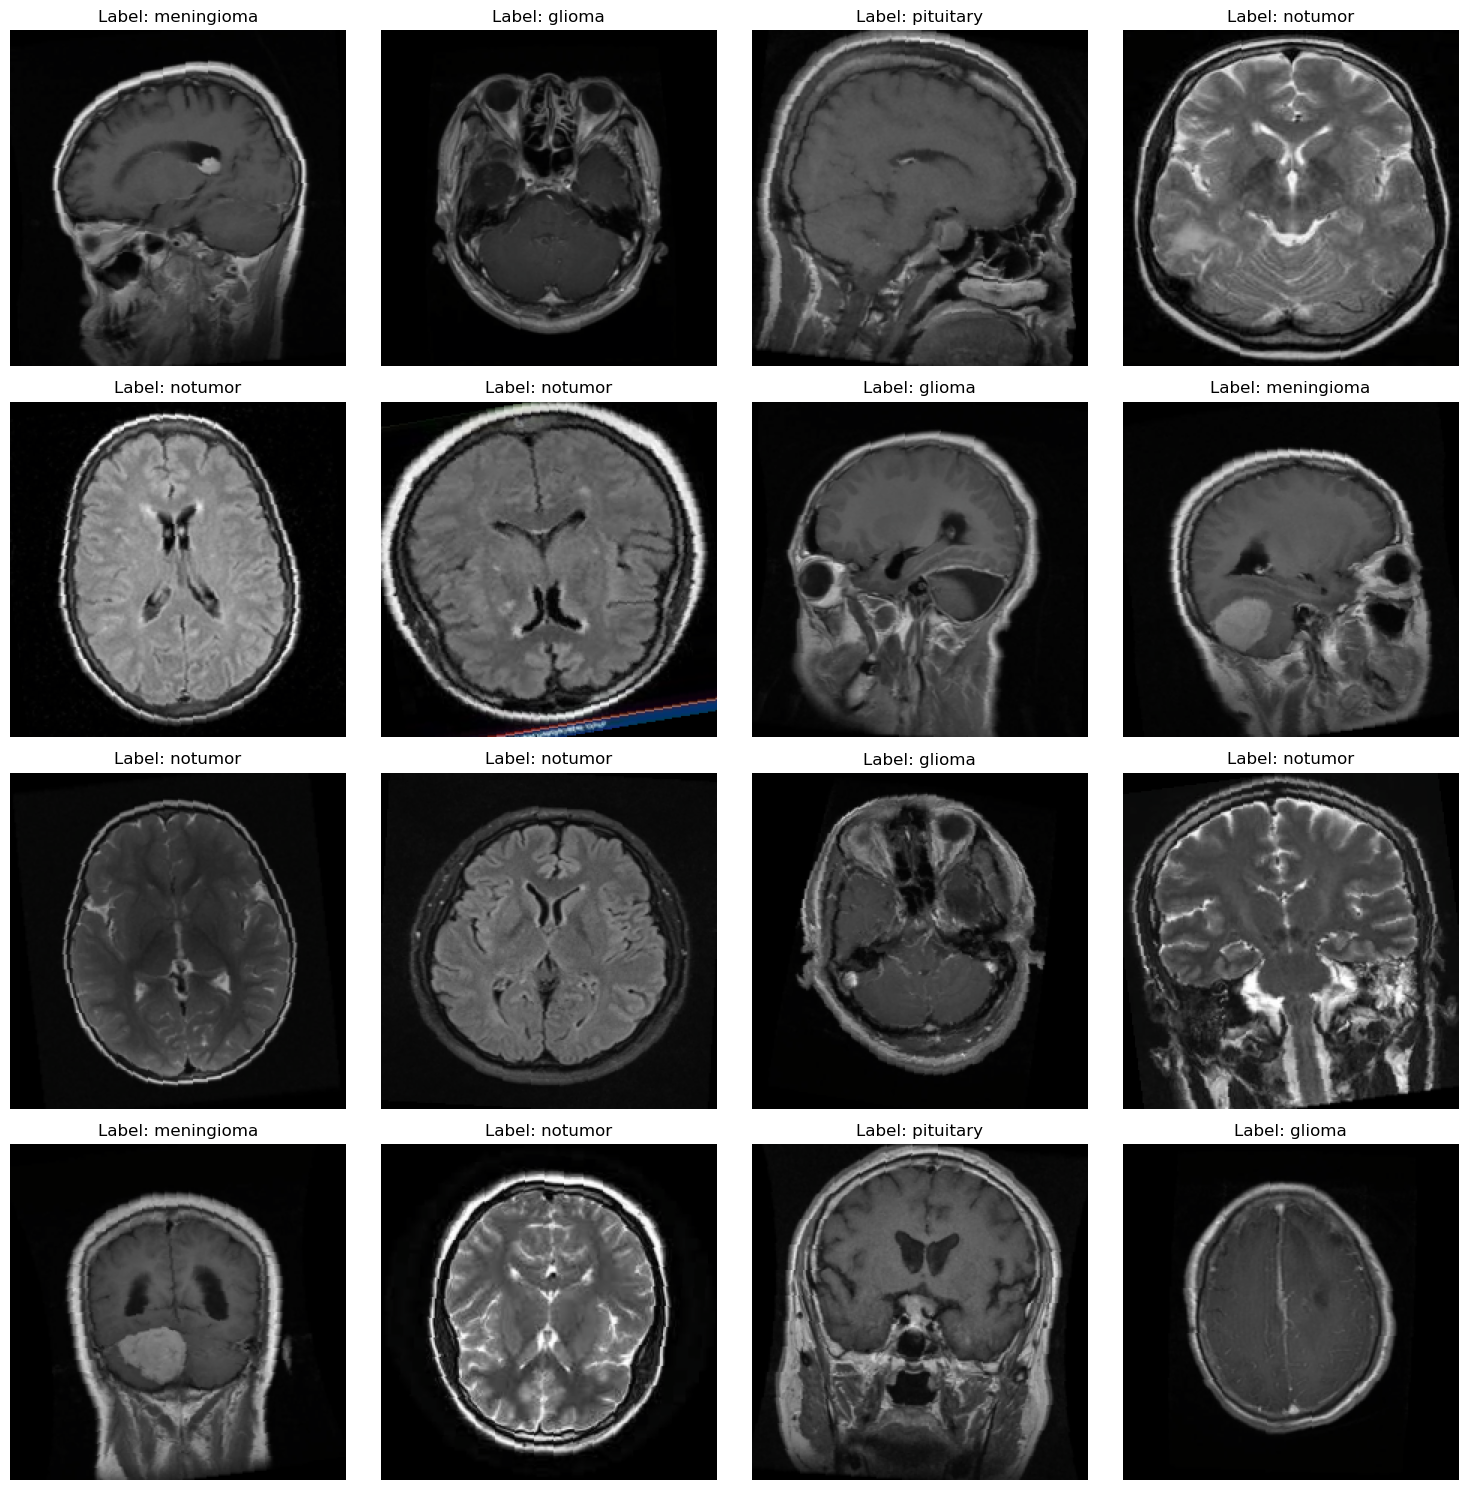

In [7]:
# Load a batch of images and labels for visualization
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert images to numpy arrays and denormalize
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = (images.numpy().transpose((0, 2, 3, 1)) * std + mean).clip(0, 1)

# Create a grid of images
num_images = len(images)
rows = int(np.ceil(num_images / 4))
fig, axes = plt.subplots(rows, 4, figsize=(15, 15))

# Plot images with labels
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f'Label: {train_dataset.classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Model Architecture

In [32]:
import torch
import torch.nn as nn
from timm import create_model

class HybridViTGRUClassifier(nn.Module):
    def __init__(self, num_classes, vit_model_name='vit_base_patch16_224', gru_hidden_size=1024, dropout=0.5):
        super(HybridViTGRUClassifier, self).__init__()

        # Load a pre-trained Vision Transformer model (ViT) without the classifier head
        self.vit = create_model(vit_model_name, pretrained=True, num_classes=0)  # No classification head
        self.vit_head_in_features = self.vit.num_features  # Typically 768 for ViT Base
        self.vit.head = nn.Identity()  # Remove the classifier head
        
        # Fine-tuning ViT: unfreeze transformer layers after some initial layers
        for param in self.vit.parameters():
            param.requires_grad = False  # Freeze all parameters
        for param in self.vit.blocks[6:].parameters():  # Fine-tune the last layers (optional)
            param.requires_grad = True

        # GRU layer for temporal modeling
        self.gru = nn.GRU(input_size=self.vit_head_in_features, 
                          hidden_size=gru_hidden_size, 
                          num_layers=2, 
                          batch_first=True, 
                          dropout=dropout, 
                          bidirectional=True)
        
        # Layer normalization to stabilize training
        self.layer_norm = nn.LayerNorm(gru_hidden_size * 2)  # Bidirectional GRU output

        # Fully connected layers for final classification
        self.fc = nn.Sequential(
            nn.Linear(gru_hidden_size * 2, 512),  # GRU is bidirectional, so multiply hidden size by 2
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Ensure input has batch and sequence dimensions
        if len(x.shape) == 4:  # Single image input: (batch_size, channels, height, width)
            x = x.unsqueeze(1)  # Add a dummy sequence dimension: (batch_size, 1, channels, height, width)

        batch_size, seq_len, channels, height, width = x.shape
        
        # Flatten the sequence dimension for batch processing in ViT
        x = x.view(batch_size * seq_len, channels, height, width)  # Shape: (batch_size * seq_len, channels, height, width)
        
        # Extract features from ViT
        vit_features = self.vit(x)  # Shape: (batch_size * seq_len, vit_features)
        
        # Check if vit_features is None
        if vit_features is None:
            raise ValueError("ViT feature extraction failed. Check the input image size or model setup.")

        # Reshape back to sequence format for GRU
        vit_features = vit_features.view(batch_size, seq_len, -1)  # Shape: (batch_size, seq_len, vit_features)

        # Pass the features through the GRU
        gru_out, _ = self.gru(vit_features)  # GRU output shape: (batch_size, seq_len, hidden_size * 2)

        # Apply layer normalization on GRU output
        gru_out_last = self.layer_norm(gru_out[:, -1, :])  # Get the last sequence element

        # Pass through fully connected layers for final classification
        output = self.fc(gru_out_last)
        
        return output


model = HybridViTGRUClassifier(num_classes=4)
# Load a pre-trained ResNet model and modify the classifier
model.to(device)

HybridViTGRUClassifier(
  (vit): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate

In [33]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Model Training

In [41]:
# Initialize lists to store training history
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
train_all_preds = []
train_all_labels = []
val_all_preds = []
val_all_labels = []

Epoch 1/5
Epoch 1/5 - Train Loss: 0.4584, Train Accuracy: 0.8242, Val Loss: 0.4095, Val Accuracy: 0.8368


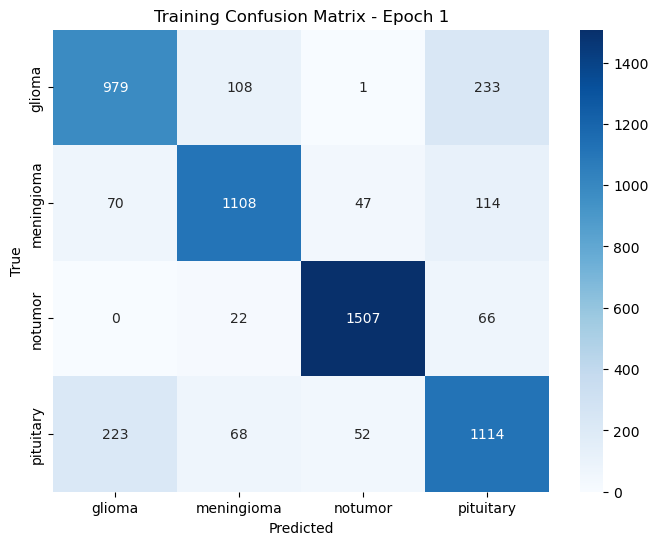

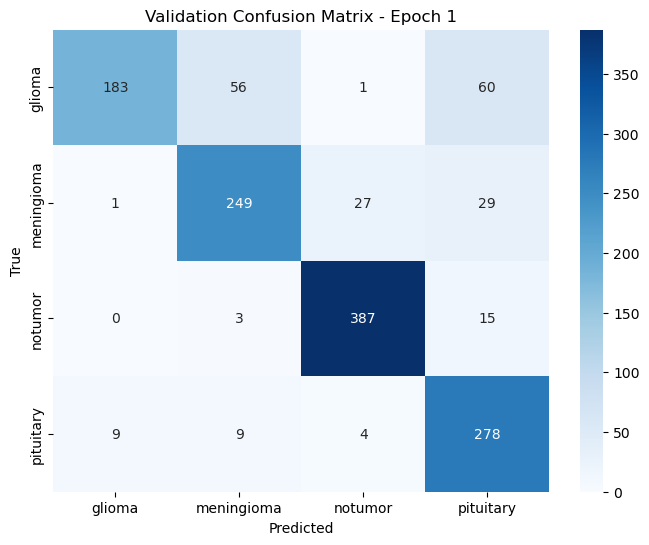

Epoch 2/5
Epoch 2/5 - Train Loss: 0.4184, Train Accuracy: 0.8549, Val Loss: 0.3426, Val Accuracy: 0.8833


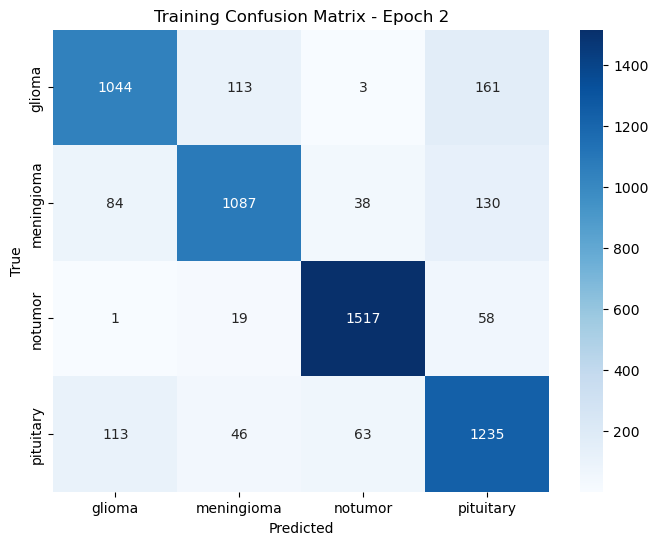

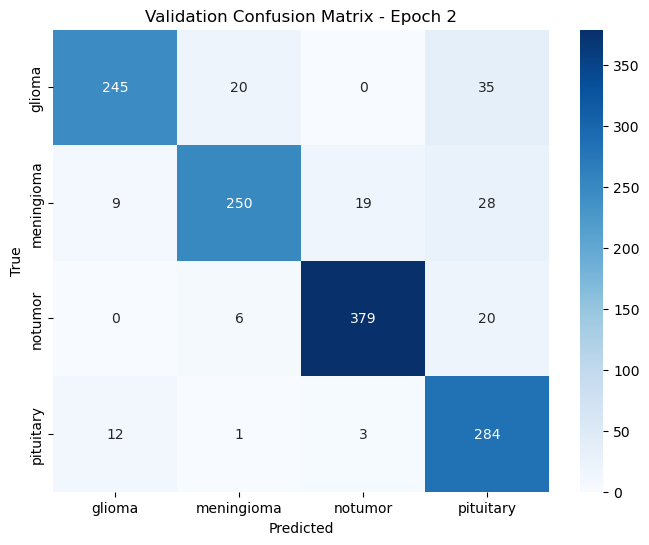

Epoch 3/5
Epoch 3/5 - Train Loss: 0.3514, Train Accuracy: 0.8811, Val Loss: 0.2674, Val Accuracy: 0.9054


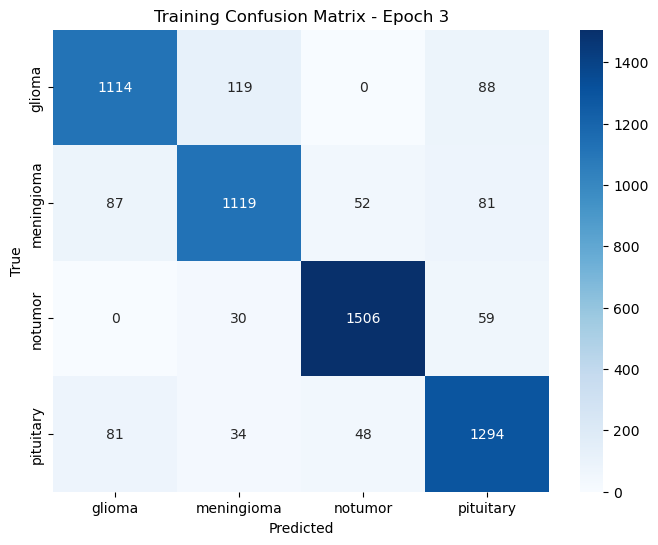

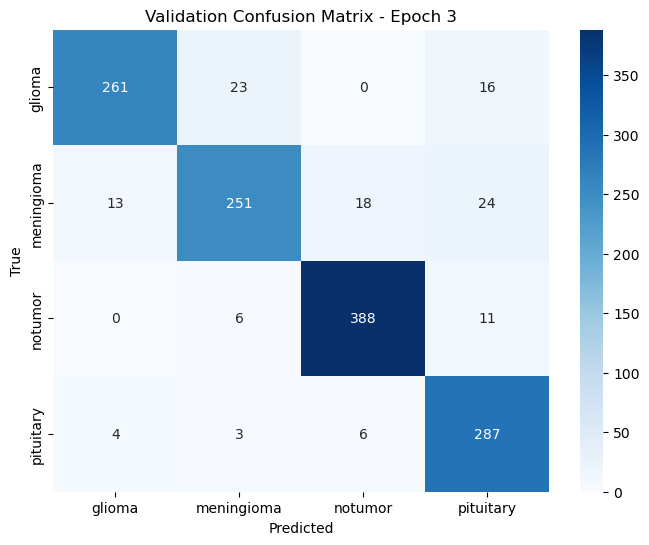

Epoch 4/5
Epoch 4/5 - Train Loss: 0.3017, Train Accuracy: 0.8974, Val Loss: 0.3684, Val Accuracy: 0.8513


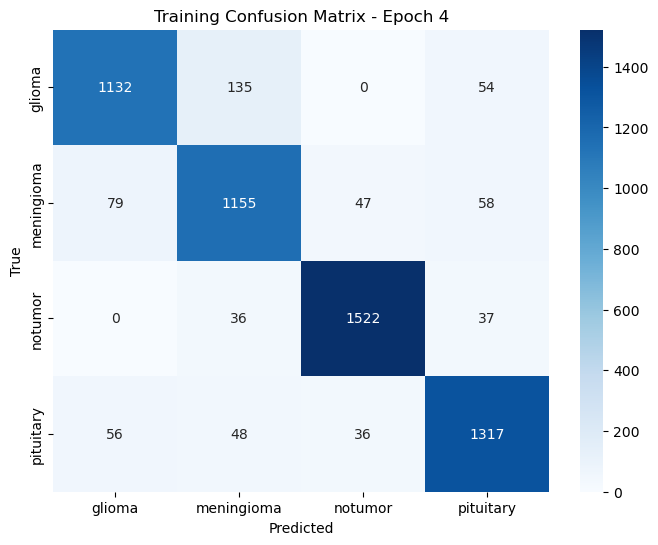

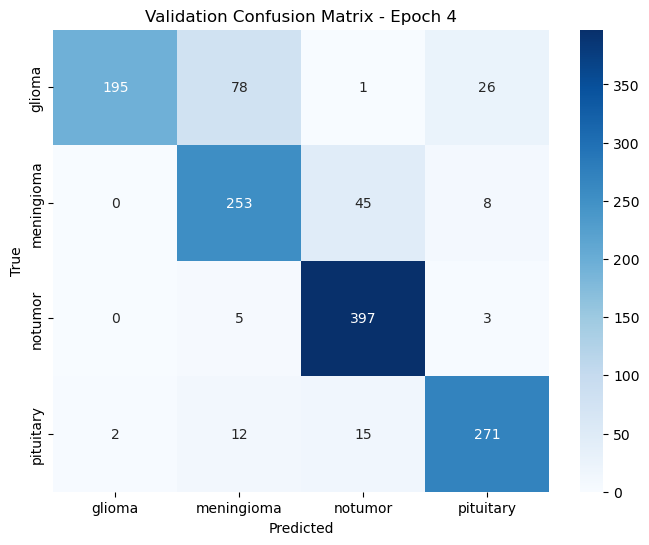

Epoch 5/5
Epoch 5/5 - Train Loss: 0.3114, Train Accuracy: 0.8901, Val Loss: 0.2666, Val Accuracy: 0.9016


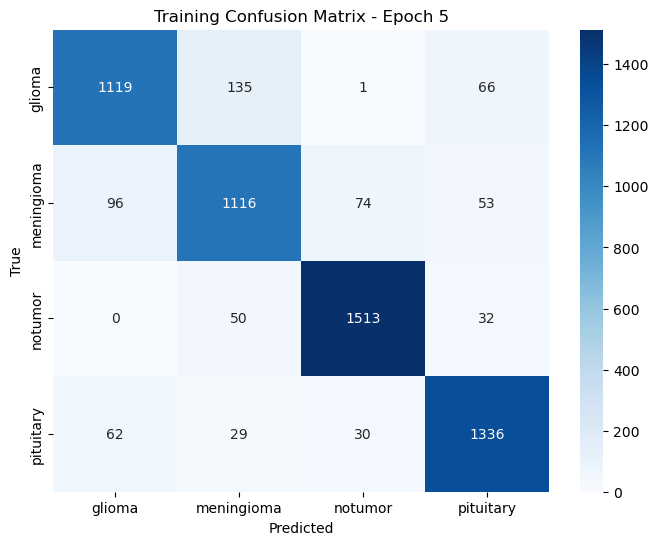

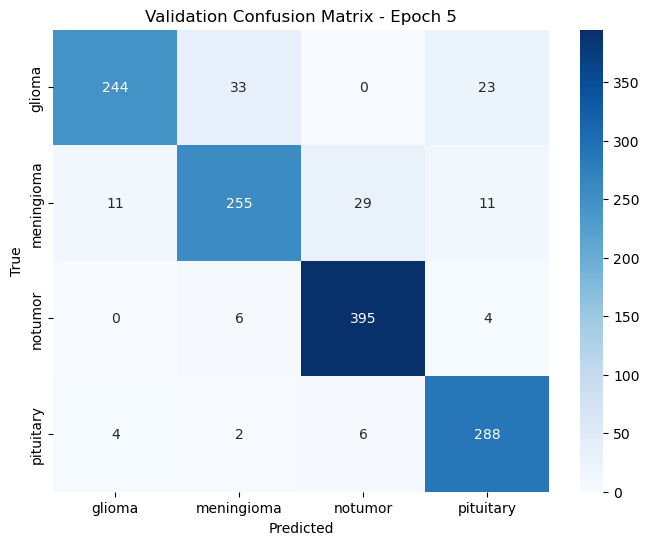

In [94]:
num_epochs = 5

# Store metrics for plotting
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_precisions, train_recalls, train_f1_scores = [], [], []
val_precisions, val_recalls, val_f1_scores = [], [], []

# Start your training loop
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')

    # ========================== Training Phase ============================
    model.train()  # Set model to training mode
    running_loss = 0.0
    all_labels = []
    all_preds = []

    for inputs, labels in train_loader:  # train_loader should be defined
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item() * inputs.size(0)

        # Store predictions and labels for later metric calculations
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    # Calculate training loss and append to the list
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Calculate metrics for training
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_precision = precision_score(all_labels, all_preds, average='macro')  # Adjust to the appropriate average method
    train_recall = recall_score(all_labels, all_preds, average='macro')  # Adjust as needed
    train_f1 = f1_score(all_labels, all_preds, average='macro')  # Adjust as needed

    # Store training metrics
    train_accuracies.append(train_accuracy)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1_scores.append(train_f1)

    # ========================== Validation Phase ============================
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_labels = []
    val_preds = []

    with torch.no_grad():  # Disable gradient tracking during evaluation
        for inputs, labels in val_loader:  # val_loader should be defined
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass (no gradient computation)
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            # Store predictions and labels for later metric calculations
            _, preds = torch.max(outputs, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(preds.cpu().numpy())

    # Calculate validation loss and append to the list
    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    # Calculate metrics for validation
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_precision = precision_score(val_labels, val_preds, average='macro')  # Adjust to the appropriate average method
    val_recall = recall_score(val_labels, val_preds, average='macro')  # Adjust as needed
    val_f1 = f1_score(val_labels, val_preds, average='macro')  # Adjust as needed

    # Store validation metrics
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1)

    # Print metrics for this epoch
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Plot confusion matrix for training phase
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_loader.dataset.classes, yticklabels=train_loader.dataset.classes)
    plt.title(f'Training Confusion Matrix - Epoch {epoch+1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Plot confusion matrix for validation phase
    cm_val = confusion_matrix(val_labels, val_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=val_loader.dataset.classes, yticklabels=val_loader.dataset.classes)
    plt.title(f'Validation Confusion Matrix - Epoch {epoch+1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


# Model Evaluation

Length of train_losses: 5
Length of val_losses: 5
Length of train_accuracies: 5
Length of val_accuracies: 5


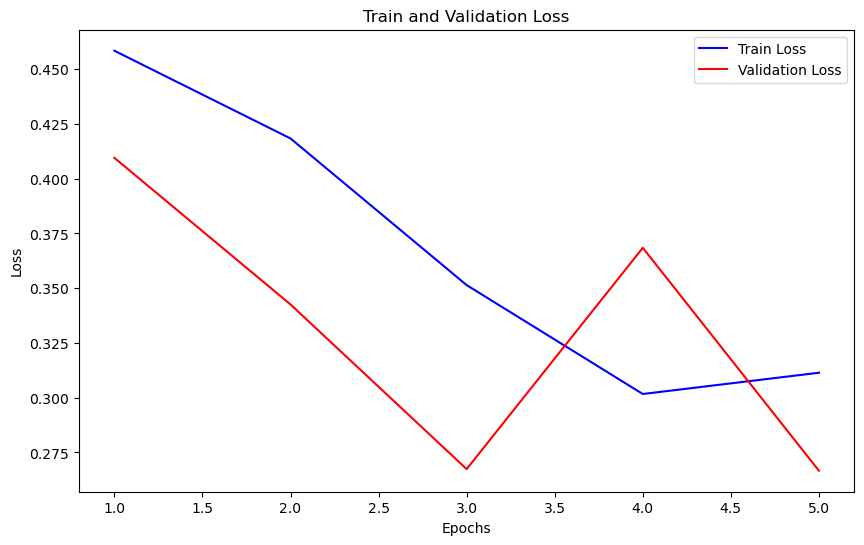

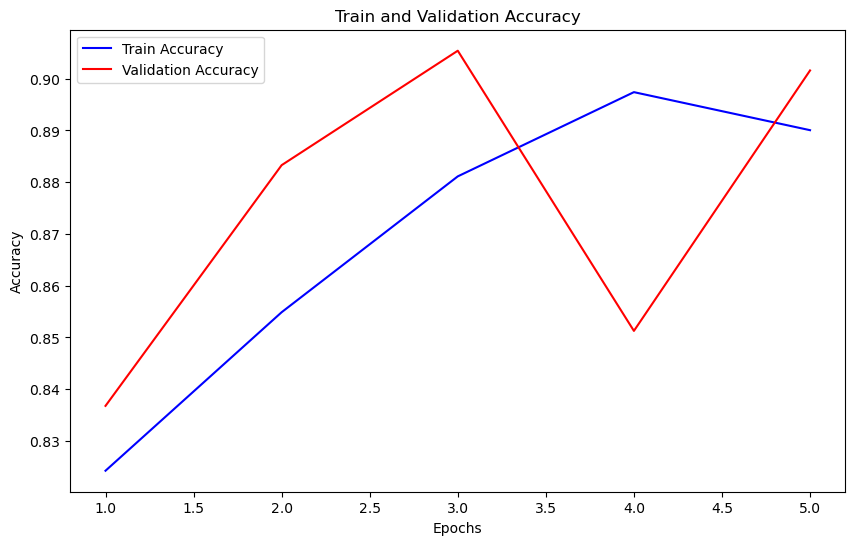

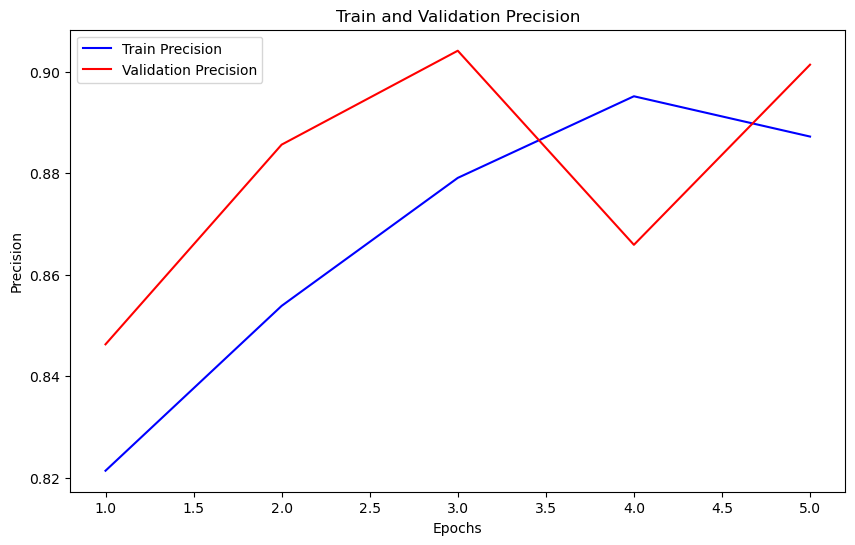

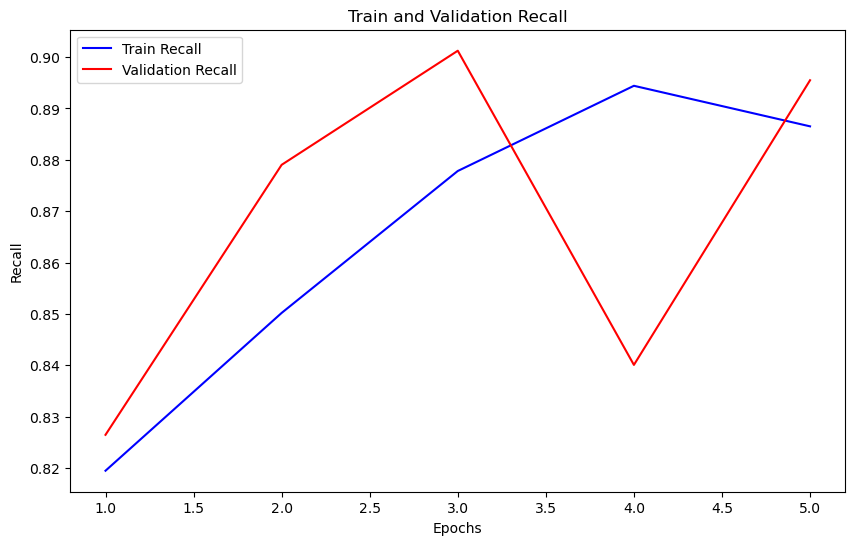

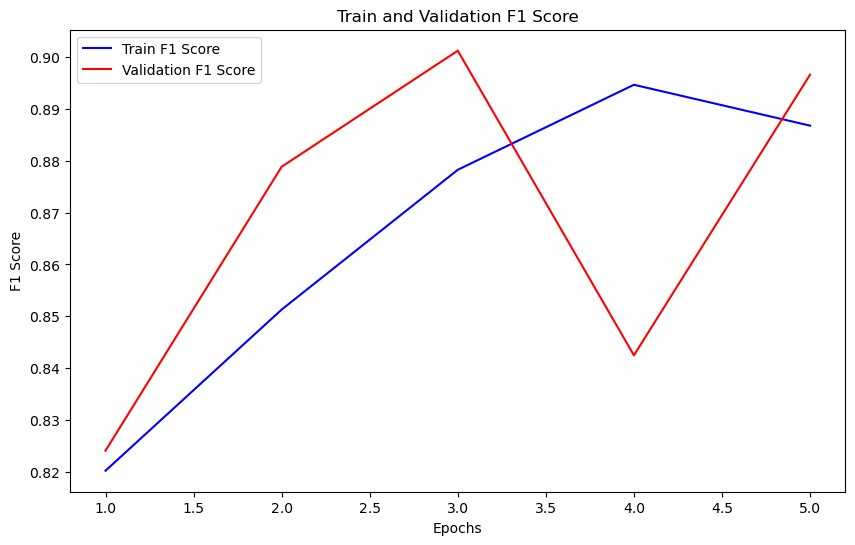

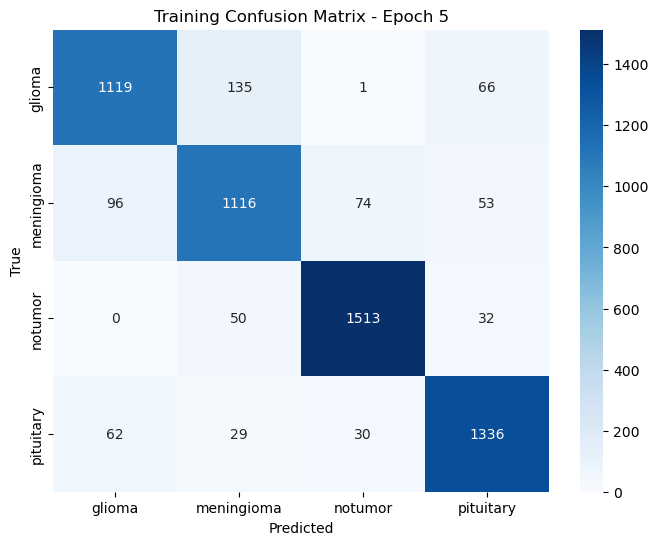

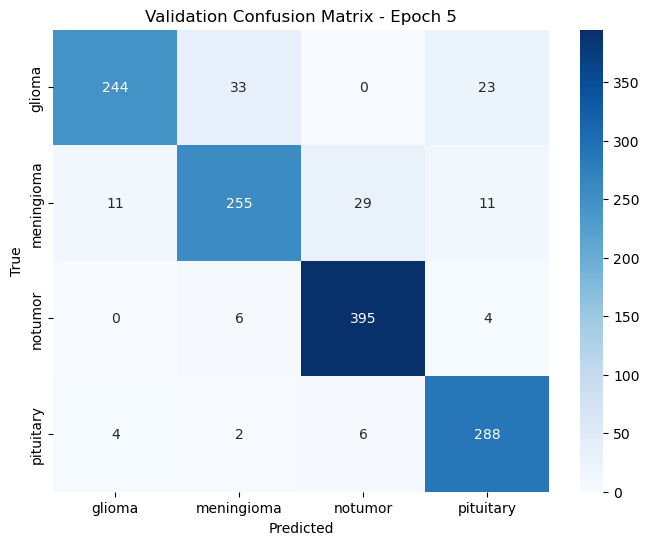

Epoch 5/5 - Train Loss: 0.3114, Train Accuracy: 0.8901, Val Loss: 0.2666, Val Accuracy: 0.9016


In [98]:
# Check the lengths of the lists before assertion
print(f"Length of train_losses: {len(train_losses)}")
print(f"Length of val_losses: {len(val_losses)}")
print(f"Length of train_accuracies: {len(train_accuracies)}")
print(f"Length of val_accuracies: {len(val_accuracies)}")

# Ensure all lists are the same length as num_epochs before plotting
assert len(train_losses) == len(val_losses) == len(train_accuracies) == len(val_accuracies) == num_epochs, \
    f"Lengths mismatch: train_losses({len(train_losses)}), val_losses({len(val_losses)}), train_accuracies({len(train_accuracies)}), val_accuracies({len(val_accuracies)})"

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation precision
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_precisions, label='Train Precision', color='blue')
plt.plot(range(1, num_epochs+1), val_precisions, label='Validation Precision', color='red')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Train and Validation Precision')
plt.legend()
plt.show()

# Plot training and validation recall
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_recalls, label='Train Recall', color='blue')
plt.plot(range(1, num_epochs+1), val_recalls, label='Validation Recall', color='red')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Train and Validation Recall')
plt.legend()
plt.show()

# Plot training and validation F1 score
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_f1_scores, label='Train F1 Score', color='blue')
plt.plot(range(1, num_epochs+1), val_f1_scores, label='Validation F1 Score', color='red')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Train and Validation F1 Score')
plt.legend()
plt.show()

# ========================== Confusion Matrix ============================
# Plot confusion matrix for training phase
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_loader.dataset.classes, yticklabels=train_loader.dataset.classes)
plt.title(f'Training Confusion Matrix - Epoch {epoch+1}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot confusion matrix for validation phase
cm_val = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=val_loader.dataset.classes, yticklabels=val_loader.dataset.classes)
plt.title(f'Validation Confusion Matrix - Epoch {epoch+1}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(f"Epoch {epoch+1}/{num_epochs} - "
      f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
      f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, Dropout

def create_model(input_shape):
    modeltwo = tf.keras.Sequential([
        # CNN layers
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),   


        # LSTM layer
        LSTM(64, return_sequences=False),
        Dropout(0.2),

        # Dense layers
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')  # For binary classification
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])   

    return modeltwo

modeltwo = HybridViTGRUClassifier(num_classes=4)
# Load a pre-trained ResNet model and modify the classifier
modeltwo.to(device)

# Saving Model

In [99]:
torch.save(model.state_dict(), 'best_model.pth')
print('Model Saved Sucssfully !')

Model Saved Sucssfully !
